TODO list:

- test communication with all servos at once

In [1]:
from __future__ import division

import serial
import numpy as np
from collections import defaultdict
import Queue
import time
import threading
import matplotlib.pyplot as plt
%matplotlib inline

from rtlsdr import RtlSdr, librtlsdr, helpers

In [2]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = np.floor(len(x)/N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return np.r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X**2),axis=0)

def maxPower(x, N=256, fs=1, M=None):
    M = np.floor(len(x)/N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return abs(X).T.max(axis=0)

# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=plt.figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,np.zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[np.r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * np.hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [3]:
class Servos:
    """
    Commands servos via serial port
    """
    
    def __init__(self, num_servos, port, baudrate=115200, offset=0.0):
        self.offset = offset
        self.min_angle = -np.pi/4.
        self.max_angle = np.pi/4.
        
        self.num_servos = num_servos
        self.serial = serial.Serial(port, baudrate=baudrate)
        self.curr_angles = [0]*self.num_servos
        self.set_angles(self.curr_angles)
    
    def is_valid_angles(self, angles):
        is_valid = len(angles) == self.num_servos
        for angle in angles:
            is_valid = is_valid and (self.min_angle <= angle <= self.max_angle)
            if not is_valid:
                print('WARNING: angle {0} not in [{1},{2}]'.format(angle, self.min_angle, self.max_angle))
        return is_valid
    
    def get_angles(self):
        return list(self.curr_angles)
        
    def set_angles(self, des_angles, speed=None, fs=100.):
        """
        :param des_angle: desired angles (radians). None means don't move
        :param speed: if None, go as fast as possible. Else rad/s
        :param fs: if speed is not None, command discretization
        """
        des_angles = list(des_angles)
        for i, des_angle in enumerate(des_angles):
            if des_angle is None:
                des_angles[i] = self.curr_angles[i]
        
        if speed is None:
            self.write(des_angles)
        else:
            angle_trajs = list()
            # create trajectories
            for curr_angle, des_angle in zip(self.curr_angles, des_angles):
                sign = 1 if des_angle > curr_angle else -1
                angle_traj = [curr_angle] + list(np.r_[curr_angle:des_angle:sign*speed/fs])
                angle_trajs.append(angle_traj)
            
            # make them all the same length
            max_angle_traj_len = max(len(traj) for traj in angle_trajs)
            for i, traj in enumerate(angle_trajs):
                pad_len = max_angle_traj_len - len(traj)
                if pad_len > 0:
                    angle_trajs[i] = np.pad(np.array(traj), (1, pad_len-1), 'edge')
                
            angle_trajs = np.array(angle_trajs).T
            for angles in angle_trajs:
                self.write(angles, fs)
            
    def write(self, angles, fs=100.):
        """
        :param angles: list of desired angles
        :param fs: how long to sleep between writes
        """
        if not self.is_valid_angles(angles):
            return
        
        write_str = ''
        for i, angle in enumerate(angles):
            if angle is None:
                angle = self.curr_angles[i]
            write_str = '{0}{1:.2f}\n'.format(i, self.offset+angle)
            self.serial.write(write_str)
            time.sleep(1/(self.num_servos*fs))
            self.curr_angles[i] = angle
        
servos = Servos(3, '/dev/ttyACM1')

In [15]:
#####################
# Test ServosSerial #
#####################

curr_angles = servos.get_angles()
des_angles = [0., 0., 0.]
speed = 0.5
expected_time = abs(des_angles[0] - curr_angles[0])/speed

start = time.time()
servos.set_angles(des_angles, speed=speed)
end = time.time()

print('Expected time: {0}'.format(expected_time))
print('Elapsed: {0}'.format(end - start))

Expected time: 1.0
Elapsed: 1.18015193939


In [53]:
class SDRs:
    """
    Functionality for multiple SDRs (non-blocking)
    """
    def __init__(self, rtlsdrs, fc, fs=2.4e6, gain=0.1): # 2.4e5
        self.rtlsdrs = rtlsdrs
        for rtlsdr in self.rtlsdrs:
            if rtlsdr is None:
                continue
            rtlsdr.sample_rate = fs
            rtlsdr.center_freq = fc
            rtlsdr.gain = gain
            
        self.fs = fs
            
        # for asynchronous reads
        self.read_queues = [Queue.Queue() for _ in self.rtlsdrs]
        self.read_run_flags = [False]*len(self.rtlsdrs)
        self.read_is_stoppeds = [False]*len(self.rtlsdrs)
        self.read_threads = [None]*len(self.rtlsdrs)
        
    def start_read(self, ith):
        if self.read_run_flags[ith] or self.rtlsdrs[ith] is None:
            return
        
        self.read_run_flags[ith] = True
        self.read_threads[ith] = threading.Thread(target=self.run, args=(ith,))
        self.read_threads[ith].daemon = True
        self.read_threads[ith].start()                 
    
    def stop_read(self, ith):
        if not self.read_run_flags[ith] or self.rtlsdrs[ith] is None:
            return
        
        #try:
        #    self.rtlsdrs[ith].cancel_read_async()
        #except Exception as e:
        #    print('stop_read exception: {0}'.format(e))
        self.read_run_flags[ith] = False
        
        while not self.read_is_stoppeds[ith]:
            time.sleep(0.2)
        self.read_is_stoppeds[ith] = False
        
        x = []
        while not self.read_queues[ith].empty():
            x += self.read_queues[ith].get()
        return np.array(x)
    
    def run(self, ith, read_slice=0.1):
        num_samples = 256 * ((read_slice * self.fs) // 256)
        
        while self.read_run_flags[ith]:
            samples = self.rtlsdrs[ith].read_samples(num_samples)
            self.read_queues[ith].put(list(samples))
            
        self.read_is_stoppeds[ith] = True
    
    """
    def run(self, ith, M=8*1024):
        def read_cb(samples, q):
            try:
                q.put(list(maxPower(samples))) # TODO: makes everything faster?
            except Exception as e:
                print('read_cb exception: {0}'.format(e))
            
        try:
            self.rtlsdrs[ith].read_samples_async(read_cb, M, context=self.read_queues[ith])
        except Exception as e:
            print(e)
        self.read_is_stoppeds[ith] = True
    """
        
#RtlSdr.DEFAULT_ASYNC_BUF_NUMBER = 16
#RtlSdr.DEFAULT_READ_SIZE = 64
num_sdrs = 3
if 'rtlsdrs' not in locals():
    rtlsdrs = [None]*num_sdrs
for i in xrange(librtlsdr.rtlsdr_get_device_count()):
    try:
        rtlsdrs[i] = RtlSdr(i)
    except:
        rtlsdrs[i].close()
        rtlsdrs[i] = RtlSdr(i)
        
fc = 145.6e6
sdrs = SDRs(rtlsdrs, fc)

In [5]:
#############
# Test SDRs #
#############
print('Start reading')
sdrs.start_read(0)
print('Sleeping...')
time.sleep(1)
print('Stop reading')
x = np.array([])
x = sdrs.stop_read(0)
print('len(x): {0}'.format(len(x)))

Start reading
Sleeping...
Stop reading
len(x): 9375


In [60]:
class ServosSDRs:
    """
    Command servos and read from SDRs
    """
    def __init__(self, servos, sdrs):
        self.servos = servos
        self.sdrs = sdrs
        
        self.speed = np.pi/3.
        self.run_flag = False
        self.is_stopped = False
        self.angles_and_samples = [Queue.Queue() for _ in xrange(self.servos.num_servos)]
        
    def start(self, speed=None):
        if self.run_flag:
            return
        
        if speed is not None:
            self.speed = speed
        
        self.angles_and_samples = [Queue.Queue() for _ in xrange(self.servos.num_servos)]
        
        self.run_flag = True
        self.thread = threading.Thread(target=self.run, args=())
        self.thread.daemon = True
        self.thread.start()                 
    
    def stop(self):
        if not self.run_flag:
            return
        
        self.run_flag = False
        
        while not self.is_stopped:
            time.sleep(0.2)
        self.is_stopped = False
        
    def run(self, fs=200.):
        num_exceptions = 0
        self.servos.set_angles([self.servos.max_angle]*self.servos.num_servos, speed=self.speed, fs=fs)
        
        start_angle, end_angle = self.servos.max_angle, self.servos.min_angle
        while self.run_flag:
            try:
                # record, command servos, compute angles/power
                for i in xrange(self.servos.num_servos):
                    self.sdrs.start_read(i)
                self.servos.set_angles([end_angle]*self.servos.num_servos, speed=self.speed, fs=fs)
                for i in xrange(self.servos.num_servos):
                    samples = self.sdrs.stop_read(i)
                    if samples is not None:
                        angles = np.linspace(start_angle, end_angle, len(samples))
                        self.angles_and_samples[i].put([angles, samples])
                start_angle, end_angle = end_angle, start_angle
            except Exception as e:
                num_exceptions += 1
                print('ServosSdr.run exception: {0}'.format(e))
                
                if num_exceptions > 5:
                    break
            
        self.is_stopped = True
            
servos_sdrs = ServosSDRs(servos, sdrs)

In [111]:
###################
# Test ServosSDRs #
###################

ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(1)
time.sleep(0.5)

servos_sdrs.start()
print('Press enter to stop')
raw_input()
servos_sdrs.stop()        

ham.setDTR(0)

Press enter to stop



num_rots: 3


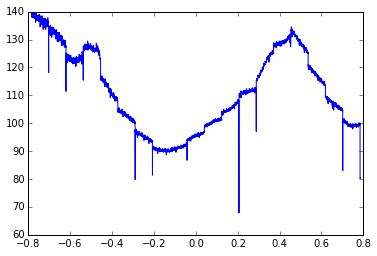

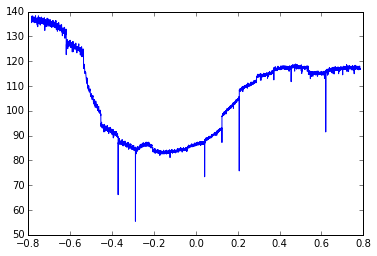

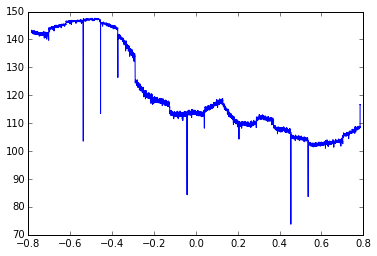

In [112]:
num_rots = 0
q = servos_sdrs.angles_and_samples[0]
while not q.empty():
    #angles, mp = q.get()
    angles, samples = q.get()
    mp = maxPower(samples)
    angles = np.linspace(angles[0], angles[-1], len(mp))
    f = plt.figure()
    plt.plot(angles, mp)
    num_rots += 1
print('num_rots: {0}'.format(num_rots))

In [95]:
#####################################
# Test shielding makes a difference #
#####################################

ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(1)
time.sleep(0.5)

"""
fs = 2400000
fc = 145.6e6 
try:
    sdr = RtlSdr()
except:
    sdr.close()
    sdr = RtlSdr()
sdr.sample_rate = fs
sdr.center_freq = fc
sdr.gain = 0.1 # 20 without antenna, 0.1 with

N_samples = 2560000*4 # approximately seconds
data = sdr.read_samples(N_samples)
"""

sdrs.start_read(0)
time.sleep(4)
data = sdrs.stop_read(0)


ham.setDTR(0)

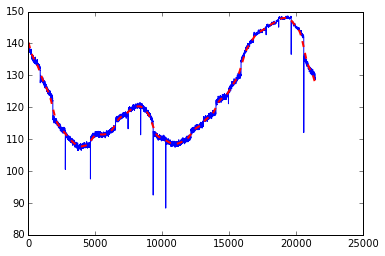

In [96]:
mp = maxPower(data)

M = 1000 # int(fs/2000)
w = np.hanning(M)
mp_smooth = np.convolve(mp, w/w.sum(), 'same')[M:-M]

plt.plot(mp[M:-M], 'b-')
plt.plot(mp_smooth, 'r--', linewidth=2)